# Übung 1 - Modellierung von PV-Stromerzeugung

Gruppe 2/B

Autoren: Ahmed Akhi, Johannes Gerger, Markus Heitzinger

In [32]:
# Import von Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

__Vorgegebene Funktion zur Bestimmung des relativen Sonnenstands:__

In [33]:
def sonnenstand(laengengrad,breitengrad,time):
    """
    Diese Funktion erstellt einen Vektor für den Sonnenstand in 15 min
    Auflösung über ein Jahr

    die Variable "azimut" ergibt einen Vektor des azimuts über ein Jahr
    der azimut ergibt nur für positive Hoehenwinkel verlässliche Werte, da
    die atan-Funktion nur Abweichungen bis zu 90° liefert. In weiteren 
    Berechnungen sollten also nur jene Werte mit positiven Hoehenwinkeln 
    (nach Sonnenaufgang) verwendet werden. Für die Berechnung von PV-Erträgen
    reicht dies vollkommen aus. 
    die Variable "hoehenwinkel" ergibt einen Vektor aller hoehenwinkel über 
    ein Jahr
    für Schaltjahre muss die Berechnung dementsprechend angepasst werden. Dies
    Anpassung muss im Rahmen dieser LV allerdings nicht berücksichtigt werden.

    Quellen zur Berechnung des Sonnenstands: Ursula Eicker(2012), 
    Jakob Anger(2012), Rainer Blabensteiner(2011)

    Args:
        laengengrad: float
        breitengrad: float
        time: pandas.Dataframe

    Returns:
        azimut: numpy.array
        hoehenwinkel: numpy.array
    
    """
    ## Zeitgleichung zur Berechnung der wahren Ortszeit
    
    # Zeitgleichung - ergibt die 
    # Abweichung der Sonnenuhr von der mittlerer Ortszeit(MOZ)
    hw1 = 360 / 365 * time['Tag'] # Hilfswinkel 1
    
    z = 0.008 * np.cos(np.radians(hw1)) - 0.122 * np.sin(np.radians(hw1)) \
        - 0.052 * np.cos(np.radians(2 * hw1)) - 0.157 * np.sin(np.radians(2 * hw1)) \
        - 0.001 * np.cos(np.radians(3 * hw1)) - 0.005 * np.sin(np.radians(3 * hw1))

    WOZ = time['Stunden'] + z + 1 / 15 * laengengrad - math.floor(1/15 * laengengrad) # Wahre Ortszeit (WOZ), der Vektor 
    # time.Stunden entspricht der mittleren Ortszeit (MOZ) in Stunden
    
    ## Stundenwinkel bei Berechnung über True Solar Time
    # time.Stunden entspricht hier der Sonnenzeit und nicht der Ortszeit
    # Stw=15*time.Stunden; #Stundenwinkel 
    # In einer Stunde legt die Sonne 15Grad zurück deswegen *15
    Stw = 15 * WOZ # Stundenwinkel
    
    ## Berechnung der Deklination
    
    Ew = 0.98630 * (np.array(time.Tag) - 2.8749) + 1.9137 * np.sin(np.radians(0.98630 * (np.array(time.Tag) - 2.8749))) + 102.06 # Ekliptikale Länge in Grad    
    Dw = np.degrees(np.arcsin(-0.3979 * np.sin(np.radians(Ew)))) # Winkel zwischen Äquatorebene und Verbindungs-
    # linie Sonne-Erde. Dieser Winkel wird als Sonnendeklination bezeichnet
    # und schwankt über das Jahr zwischen 23°26,5' und -23°26,5'

    ## Berechnung des Höhenwinkels

    hoehenwinkel = np.degrees(np.arcsin(np.sin(np.radians(Dw)) * np.sin(np.radians(breitengrad)) - np.cos(np.radians(Dw)) * np.cos(np.radians(breitengrad)) * np.cos(np.radians(Stw))))

    ## Berechnung des Azimuts
    # Winkel nach Sonnenuntergang werden hier nicht vollständig abgebildet

    azimutfull = 180 + np.degrees(np.arctan(-np.cos(np.radians(Dw)) * np.sin(np.radians(Stw)) / (-np.cos(np.radians(Dw)) * np.sin(np.radians(breitengrad)) * np.cos(np.radians(Stw)) - np.sin(np.radians(Dw)) * np.cos(np.radians(breitengrad)))))
    
    
    azimutfull[hoehenwinkel < -20] = 0 # Eliminiert
    # unter -20°

    azimutaufteilung = np.reshape(np.array(azimutfull), (96, 365), order="F") # teilt Vektor auf Tage auf
    az1 = azimutaufteilung[0:int((len(time['Stunden'])//365)//2), :] # ergibt Werte für die erste Tageshälfte
    az1[az1 > 220] = az1[az1 > 220] - 180 # Korrektur der Winkel für Abweichungen von über 90° aus Südrichtung
    az11 = az1[0:int(len(time['Stunden'])//365*0.25), :]
    az11[az11 >= 180] = az11[az11 >= 180] - 180
    az1[0:len(az11[:, 0]), :] = az11

    az2 = azimutaufteilung[int((len(time['Stunden'])//365)//2):, :] # ergibt Werte für die zweite Tageshälfte
    az2[(az2 < 150) & (az2 > 0)] = az2[(az2 < 150) & (az2 > 0)] + 180 # Korrektur der Winkel für Abweichungen von über 90° aus Südrichtung
    az22 = az2[int(len(az2[:, 0])*0.5):, :]
    az22[(az22 <= 180) & (az22 > 0)] = az22[(az22 <= 180) & (az22 > 0)] + 180
    az2[int(len(az2[:, 0])-len(az22[:, 0])):, :] = az22
    
    print(len(az1) + len(az2))
    azimutaufteilung = np.concatenate((az1, az2), axis=0) # Zusammenfassung der ersten und zweiten Tageshälfte
    azimut = np.reshape(azimutaufteilung, (35040, ), order="F") # reshape der Tage in einen Vektor aller Winkel über den Jahresverlauf in 15min Intervalle

    return azimut, hoehenwinkel


In [34]:
laengengrad=16.3
breitengrad=48.2
Installpv = 1
Modulwirkungsgrad = 0.17 # Wirkungsgrad der Panele
SonstigeVerluste = 0.8 # Wirkungsgrad aller anderen Komponenten...
Installpv = 1 # installierte Leistung der Anlage in kWp

 # Ausrichtung der PV
pv_hoehenwinkel=20  #Neigungswinkel der Anlage
pv_azimut=180       #Azimut der Anlage (Süden bei Uns)
Systemkostenkwp=2000 # €/kWp Systemkosten
A = 0.2 #Albedo
kappa = 1.041
E_0 = 1367 #W/m^2

dfTime = pd.read_csv("time.csv");
dfStrahlung = pd.read_csv("Strahlung.csv");
dfTemperatur = pd.read_csv("Temperatur.csv");

## 1. Modellimplementierung

In [35]:
def jahreserzeugung():
    dfSonnenstand = pd.DataFrame(sonnenstand(laengengrad, breitengrad,dfTime))
    dfSonnenstand = dfSonnenstand.transpose()
    dfSonnenstand.rename(columns = {0:'Azimut'}, inplace = True)
    dfSonnenstand.rename(columns = {1:'Höhenwinkel'}, inplace = True)

    dfSonnenstand["Moduleinfallswinkel"] = np.degrees(np.arccos(-np.cos(np.radians(dfSonnenstand["Höhenwinkel"]))*np.sin(np.radians(pv_hoehenwinkel)*np.cos(np.radians(dfSonnenstand["Azimut"]-pv_azimut-180)+np.sin(np.radians(dfSonnenstand["Höhenwinkel"])*np.cos(pv_hoehenwinkel))))))

    #Strahlungsenergien
        #Direkte
    dfSonnenstand["EdirGen"] = dfStrahlung["DirectHoriz"] * np.maximum(0, np.cos(np.radians(dfSonnenstand["Moduleinfallswinkel"]))/np.sin(np.radians(dfSonnenstand["Höhenwinkel"])))
    dfSonnenstand["EdirGen"] = dfSonnenstand["EdirGen"].fillna(0)
    
    dfSonnenstand["EreflGen"] = dfStrahlung["GlobalHoriz"]*A*(1/2)*(1-np.cos(np.radians(pv_hoehenwinkel)))
    dfSonnenstand["EdiffGen"] = dfStrahlung["DiffusHoriz"] * (1 + np.cos(np.radians(pv_hoehenwinkel))) / 2

    #Aus Angabe (Höhenwinkel)
    dfSonnenstand.loc[dfSonnenstand["Höhenwinkel"] < 5] = 0

    #Gesamtstrahlungsenergie
    dfSonnenstand["EgGen"] = dfSonnenstand["EdirGen"] + dfSonnenstand["EdiffGen"] + dfSonnenstand["EreflGen"]

    #Fläche der Anlage unter maximaler Leistung in m^2 (R_stc*A)
    PV_A = 1

    #Pmax = np.zeros(shape=(35040, 1)) 
    #Gesamtenergie
    Pmax = dfSonnenstand["EgGen"] * PV_A * SonstigeVerluste * 4
    

    return Pmax

In [36]:
def jahreserzeugung_temp():
    dfSonnenstand = pd.DataFrame(sonnenstand(laengengrad, breitengrad,dfTime))
    dfSonnenstand = dfSonnenstand.transpose()
    dfSonnenstand.rename(columns = {0:'Azimut'}, inplace = True)
    dfSonnenstand.rename(columns = {1:'Höhenwinkel'}, inplace = True)

    dfSonnenstand["Moduleinfallswinkel"] = np.degrees(np.arccos(-np.cos(np.radians(dfSonnenstand["Höhenwinkel"]))*np.sin(np.radians(pv_hoehenwinkel)*np.cos(np.radians(dfSonnenstand["Azimut"]-pv_azimut-180)+np.sin(np.radians(dfSonnenstand["Höhenwinkel"])*np.cos(pv_hoehenwinkel))))))

    #Strahlungsenergien
    dfSonnenstand["EdirGen"] = dfStrahlung["DirectHoriz"] * np.maximum(0, np.cos(np.radians(dfSonnenstand["Moduleinfallswinkel"]))/np.sin(np.radians(dfSonnenstand["Höhenwinkel"])))
    dfSonnenstand["EdirGen"] = dfSonnenstand["EdirGen"].fillna(0)

    dfSonnenstand["EreflGen"] = dfStrahlung["GlobalHoriz"]*A*(1/2)*(1-np.cos(np.radians(pv_hoehenwinkel)))
    dfSonnenstand["EdiffGen"] = dfStrahlung["DiffusHoriz"] * (1 + np.cos(np.radians(pv_hoehenwinkel))) / 2

    #Aus Angabe 
    dfSonnenstand.loc[dfSonnenstand["Höhenwinkel"] < 5] = 0

    #Gesamtstrahlungsenergie
    dfSonnenstand["EgGen"] = dfSonnenstand["EdirGen"]+dfSonnenstand["EdiffGen"]+dfSonnenstand["EreflGen"]




    #Temperatur_15m =  Temperatur_15m.reshape((35040, 1))
    Temperatur_15m = np.array([(x, x, x, x) for x in dfTemperatur.values]).flatten()

    #Werte aus bereitgelegter Doku Huld_et
    c_t = 0.026
    k_1 = -0.017162
    k_2 = -0.040289
    k_3 = -0.004681
    k_4 = 0.000148
    k_5 = 0.000169
    k_6 = 0.000005

#Erstellen von Spalten
    #Stralungsleistung
    G_raw = np.zeros(shape=(35040, 1)) 
    G_Hoch = np.zeros(shape=(35040, 1)) 
    #Temperaturbehafteter Wirkungsgrad
    Wirk_temp = np.zeros(shape=(35040, 1))
    
#Füllen der Spalten
    G_raw = dfSonnenstand["EgGen"] 

    for index in range(35040):
       if G_raw[index] != 0:
            G_Hoch[index] = math.log(G_raw[index]/1000)
            Wirk_temp[index] = 1 + k_1 * G_Hoch[index] + k_2 * (G_Hoch[index] ** 2) + (Temperatur_15m[index] + c_t * G_raw[index] - 25) * (k_3 + k_4 * G_Hoch[index] + k_5 * (G_Hoch[index] ** 2)) + k_6 * ((Temperatur_15m[index] + c_t * G_raw[index] - 25) ** 2)
    
    
    PV_A = 1

    Pmax = np.zeros(shape=(35040, 1)) 
    #Gesamtenergie
    for i in range(35040):
        Pmax[i] = G_raw[i] * PV_A * SonstigeVerluste * Wirk_temp[i] *4
        
    return  Pmax

In [37]:
def monthly_yield_plot(energy_array, title):
    # Creation of daily array
    E_days = np.empty(shape=(365, 1))
    for index, day in enumerate(E_days):
        E_days[index] = sum(energy_array[index*4*24:(index+1)*4*24])
    # Creation of monthly array
    month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    E_months = np.empty(shape=(12, 1))
    counter = 0
    for index, month in enumerate(month_days):
        E_months[index] = sum(E_days[counter:counter + month])
        counter += month
    fig, ax = plt.subplots()
    ax.bar(np.arange(1, 13), E_months.flatten() / 1000, zorder=2)
    ax.set_title(title)
    ax.set_xlabel('t in Months')
    ax.set_ylabel('Yield in kWh')
    ax.grid(True, zorder=1)
    plt.show()
    

## 2. Anwendung der Modelle

a.)

96
96


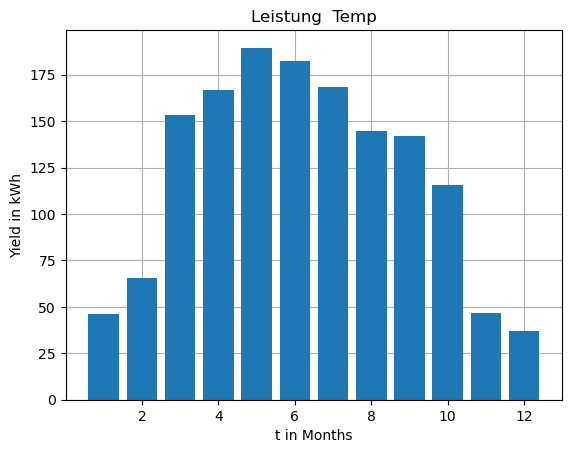

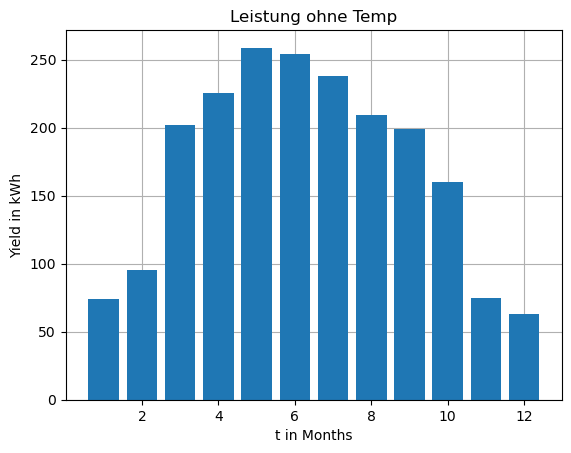

In [38]:
# Model ohne Temperatur
P_PV = jahreserzeugung()

#Model mit Temperatur
P_PV_Temp = jahreserzeugung_temp()

monthly_yield_plot(P_PV_Temp,"Leistung  Temp")
monthly_yield_plot(P_PV,"Leistung ohne Temp")


b.)

In [39]:
# Berechne die täglichen Erträge
daily_yield = np.empty(shape=(365,))
for index in range(365):
    daily_yield[index] = np.sum(P_PV[index * 24 * 4:(index + 1) * 24 * 4])

# Sortiere die täglichen Erträge in aufsteigender und absteigender Reihenfolge
sorted_daily_yield_asc = np.argsort(daily_yield)
sorted_daily_yield_desc = np.flip(sorted_daily_yield_asc)

# Wähle die ersten und letzten 5 Tage aus den sortierten Listen aus
top_5_days = sorted_daily_yield_desc[:5]
bottom_5_days = sorted_daily_yield_asc[:5]

# Definiere die Anzahl der Tage in jedem Monat
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# Gib das Datum und den energetischen Ertrag dieser Tage aus
print("5 Tage mit maximaler PV-Erzeugung:")
for day in top_5_days:
    month = 1
    while day >= days_in_month[month - 1]:
        day -= days_in_month[month - 1]
        month += 1
    print(f"Datum DD/MM: {day + 1}/{month} - Ertrag: {round(daily_yield[day], 3)} kWh")

print("\n5 Tage mit minimaler PV-Erzeugung:")
for day in bottom_5_days:
    month = 1
    while day >= days_in_month[month - 1]:
        day -= days_in_month[month - 1]
        month += 1
    print(f"Datum DD/MM: {day + 1}/{month} - Ertrag: {round(daily_yield[day], 3)} kWh")


5 Tage mit maximaler PV-Erzeugung:
Datum DD/MM: 7/7 - Ertrag: 3126.282 kWh
Datum DD/MM: 14/5 - Ertrag: 2263.536 kWh
Datum DD/MM: 6/7 - Ertrag: 1990.279 kWh
Datum DD/MM: 12/5 - Ertrag: 3181.37 kWh
Datum DD/MM: 15/6 - Ertrag: 1734.228 kWh

5 Tage mit minimaler PV-Erzeugung:
Datum DD/MM: 6/12 - Ertrag: 1990.279 kWh
Datum DD/MM: 31/12 - Ertrag: 1593.093 kWh
Datum DD/MM: 27/11 - Ertrag: 2159.33 kWh
Datum DD/MM: 3/12 - Ertrag: 2967.226 kWh
Datum DD/MM: 28/12 - Ertrag: 2766.201 kWh


In [40]:
"""
░░░░░░░█▐▓▓░████▄▄▄█▀▄▓▓▓▌█
░░░░░▄█▌▀▄▓▓▄▄▄▄▀▀▀▄▓▓▓▓▓▌█
░░░▄█▀▀▄▓█▓▓▓▓▓▓▓▓▓▓▓▓▀░▓▌█
░░█▀▄▓▓▓███▓▓▓███▓▓▓▄░░▄▓▐█▌
░█▌▓▓▓▀▀▓▓▓▓███▓▓▓▓▓▓▓▄▀▓▓▐█
▐█▐██▐░▄▓▓▓▓▓▀▄░▀▓▓▓▓▓▓▓▓▓▌█▌
█▌███▓▓▓▓▓▓▓▓▐░░▄▓▓███▓▓▓▄▀▐█
█▐█▓▀░░▀▓▓▓▓▓▓▓▓▓██████▓▓▓▓▐█
▌▓▄▌▀░▀░▐▀█▄▓▓██████████▓▓▓▌█▌
▌▓▓▓▄▄▀▀▓▓▓▀▓▓▓▓▓▓▓▓█▓█▓█▓▓▌█▌
█▐▓▓▓▓▓▓▄▄▄▓▓▓▓▓▓█▓█▓█▓█▓▓▓▐█
"""

'\n░░░░░░░█▐▓▓░████▄▄▄█▀▄▓▓▓▌█\n░░░░░▄█▌▀▄▓▓▄▄▄▄▀▀▀▄▓▓▓▓▓▌█\n░░░▄█▀▀▄▓█▓▓▓▓▓▓▓▓▓▓▓▓▀░▓▌█\n░░█▀▄▓▓▓███▓▓▓███▓▓▓▄░░▄▓▐█▌\n░█▌▓▓▓▀▀▓▓▓▓███▓▓▓▓▓▓▓▄▀▓▓▐█\n▐█▐██▐░▄▓▓▓▓▓▀▄░▀▓▓▓▓▓▓▓▓▓▌█▌\n█▌███▓▓▓▓▓▓▓▓▐░░▄▓▓███▓▓▓▄▀▐█\n█▐█▓▀░░▀▓▓▓▓▓▓▓▓▓██████▓▓▓▓▐█\n▌▓▄▌▀░▀░▐▀█▄▓▓██████████▓▓▓▌█▌\n▌▓▓▓▄▄▀▀▓▓▓▀▓▓▓▓▓▓▓▓█▓█▓█▓▓▌█▌\n█▐▓▓▓▓▓▓▄▄▄▓▓▓▓▓▓█▓█▓█▓█▓▓▓▐█\n'

c.)

In [41]:
# Berechne die täglichen Erträge
daily_yield = np.empty(shape=(365,))
for index in range(365):
    daily_yield[index] = np.sum(P_PV[index * 24 * 4:(index + 1) * 24 * 4])

# Sortiere die täglichen Erträge in aufsteigender und absteigender Reihenfolge
sorted_daily_yield_asc = np.argsort(daily_yield)
sorted_daily_yield_desc = np.flip(sorted_daily_yield_asc)

# Wähle die ersten und letzten 5 Tage aus den sortierten Listen aus
top_5_days = sorted_daily_yield_desc[:5]
bottom_5_days = sorted_daily_yield_asc[:5]

# Gib das Datum und den energetischen Ertrag dieser Tage aus
print("Top 5 Tage mit maximaler PV-Erzeugung:")
for day in top_5_days:
    print(f"Tag: {day }/365 - Monat: {day // 30 }/12 - Ertrag: {daily_yield[day]} kWh")

print("\nBottom 5 Tage mit minimaler PV-Erzeugung:")
for day in bottom_5_days:
    print(f"Tag: {day }/365 - Monat: {day // 30 }/12 - Ertrag: {daily_yield[day]} kWh")


Top 5 Tage mit maximaler PV-Erzeugung:
Tag: 187/365 - Monat: 6/12 - Ertrag: 9735.454661525699 kWh
Tag: 133/365 - Monat: 4/12 - Ertrag: 9706.488749733262 kWh
Tag: 186/365 - Monat: 6/12 - Ertrag: 9611.607217389512 kWh
Tag: 131/365 - Monat: 4/12 - Ertrag: 9479.268556658957 kWh
Tag: 165/365 - Monat: 5/12 - Ertrag: 9479.152489499793 kWh

Bottom 5 Tage mit minimaler PV-Erzeugung:
Tag: 339/365 - Monat: 11/12 - Ertrag: 857.3298772518369 kWh
Tag: 364/365 - Monat: 12/12 - Ertrag: 927.1675399883566 kWh
Tag: 330/365 - Monat: 11/12 - Ertrag: 927.6679717861678 kWh
Tag: 336/365 - Monat: 11/12 - Ertrag: 966.4034484407376 kWh
Tag: 361/365 - Monat: 12/12 - Ertrag: 972.1957447092758 kWh


d.

In [42]:
# Berechne die Anteile der diffusen, direkten und reflektierten Strahlung an jedem Tag
Gesamtstrahlung = (dfStrahlung["DiffusHoriz"] + dfStrahlung["DirectInclined"] + dfStrahlung["Reflected"])
Gesamtstrahlung.groupby(Gesamtstrahlung.index // 96).sum()
diffuse_fraction = dfStrahlung["DiffusHoriz"] / Gesamtstrahlung
direct_fraction = dfStrahlung["DirectInclined"] / Gesamtstrahlung
reflected_fraction = dfStrahlung["Reflected"] / Gesamtstrahlung



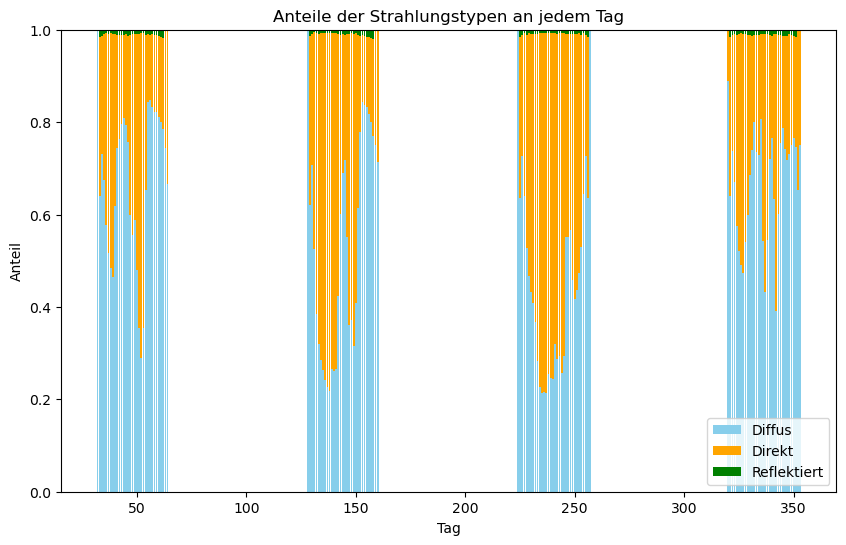

In [43]:


# Erstelle das Diagramm
fig, ax = plt.subplots(figsize=(10, 6))
days = np.arange(1, 366)
ax.bar(days, diffuse_fraction[:365], label='Diffus', color='skyblue')
ax.bar(days, direct_fraction[:365], bottom=diffuse_fraction[:365], label='Direkt', color='orange')
ax.bar(days, reflected_fraction[:365], bottom=diffuse_fraction[:365] + direct_fraction[:365], label='Reflektiert', color='green')
ax.set_title('Anteile der Strahlungstypen an jedem Tag')
ax.set_xlabel('Tag')
ax.set_ylabel('Anteil')
ax.legend()
plt.show()

e.)

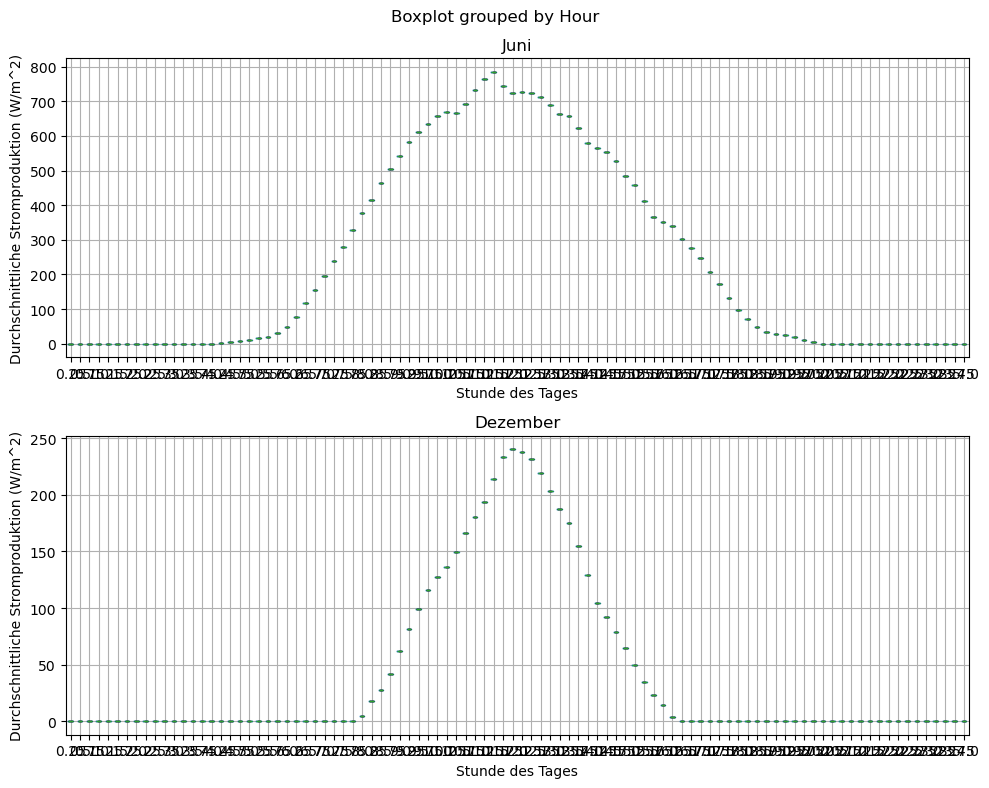

In [44]:
# Extrahiere die Daten für die Monate Juni und Dezember
june_data = dfStrahlung[(dfStrahlung['Month'] == 6)]
december_data = dfStrahlung[(dfStrahlung['Month'] == 12)]

# Berechne den Durchschnitt der Stromproduktion für jede Stunde des Tages für Juni und Dezember
june_hourly_average = june_data.groupby(june_data['Hour']).mean() * 4
june_hourly_average['GlobalInclined'] = june_hourly_average['GlobalInclined']  # Durchschnitt für 4 Werte
december_hourly_average = december_data.groupby(december_data['Hour']).mean() * 4
december_hourly_average['GlobalInclined'] = december_hourly_average['GlobalInclined']  # Durchschnitt für 4 Werte

# Erstelle Boxplots für die durchschnittliche Stromproduktion für jede Stunde des Tages für Juni und Dezember
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
june_hourly_average.boxplot(column='GlobalInclined', by='Hour', ax=axes[0])
axes[0].set_title('Juni')
axes[0].set_xlabel('Stunde des Tages')
axes[0].set_ylabel('Durchschnittliche Stromproduktion (W/m^2)')

december_hourly_average.boxplot(column='GlobalInclined', by='Hour', ax=axes[1])
axes[1].set_title('Dezember')
axes[1].set_xlabel('Stunde des Tages')
axes[1].set_ylabel('Durchschnittliche Stromproduktion (W/m^2)')

plt.tight_layout()
plt.show()
